In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df= pd.read_csv("./GraphM/annthyroid_21feat_normalised.csv")


# 라벨 및 특성 분리
labels = df['class']
x = df.drop(columns=['class'])

# 먼저 train (70%) vs temp (30%) 분리
x_train, x_temp, y_train, y_temp = train_test_split(
    x, labels, test_size=0.3, random_state=42, stratify=labels
)

# temp를 다시 validation (20%) vs test (10%)로 분리
# 비율 상으로는 temp의 2/3가 val, 1/3이 test → test_size=1/3 = 0.33
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

# 결과 shape 확인 (선택)
print(f"Train: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")


# 각각 합쳐서 build_graph에 넣을 수 있는 형태로
df_train = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_val, y_val], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)


Train: (5040, 21), Validation: (1447, 21), Test: (713, 21)


In [12]:
y_test.value_counts()

class
0    660
1     53
Name: count, dtype: int64

# 시각화 & 평가지표 함수

In [3]:
# from visev import *로 정리

# Euclidian 으로 확인한 실험 전 test dataset 상태

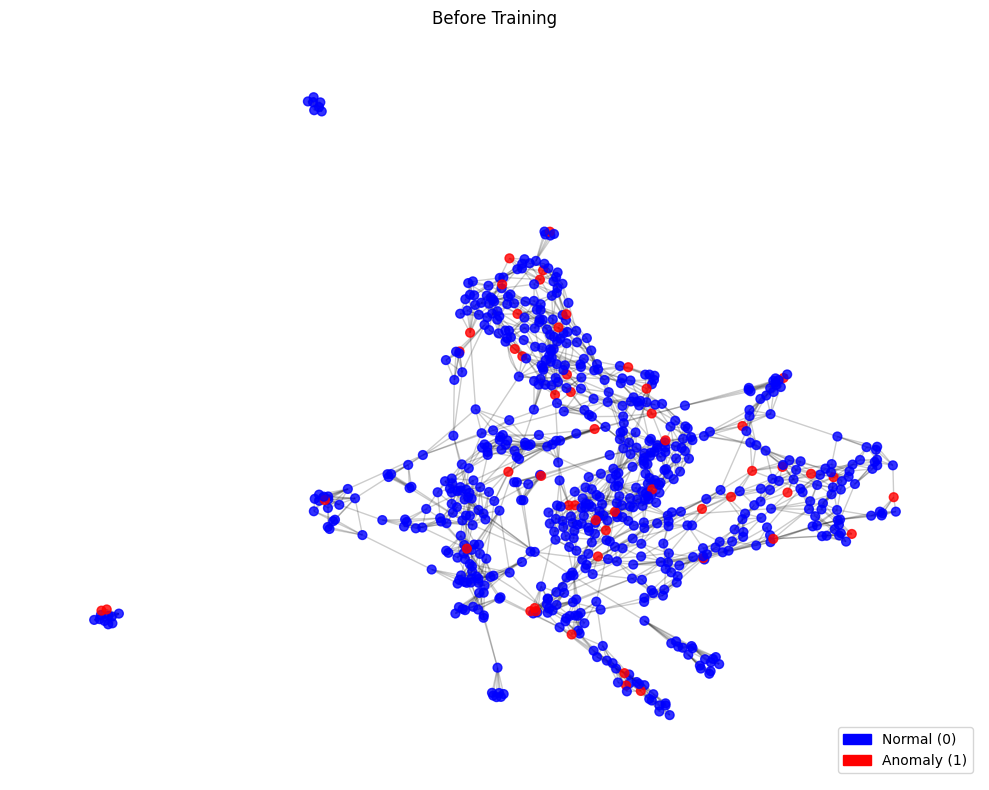

In [2]:
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
from visev import *

# ✅ 고정 k-NN 그래프 생성
def build_fixed_graph(dataframe, k=5):
    x = torch.tensor(dataframe.drop(columns=['class']).values, dtype=torch.float)
    y = torch.tensor(dataframe['class'].values, dtype=torch.float)

    nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(x)
    _, indices = nbrs.kneighbors(x)

    edge_index = []
    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return x, edge_index, y

x_test, edge_index_test, y_test = build_fixed_graph(df_test)
data_test = Data(x=x_test, edge_index=edge_index_test, y=y_test)

# 기존 데이터 시각화
visualize_graph(data_test, title="Before Training")

In [4]:
from visev import *


visualize_graph_3d_rotate(data_test)


✅ Saved rotation frames to: rotation_frames/


In [3]:
from visev import *

visualize_graph_3d_spherical_rotation(data_test)

✅ Spherical rotated images saved to rotation_sphere/


# GCN

Early stopping triggered.


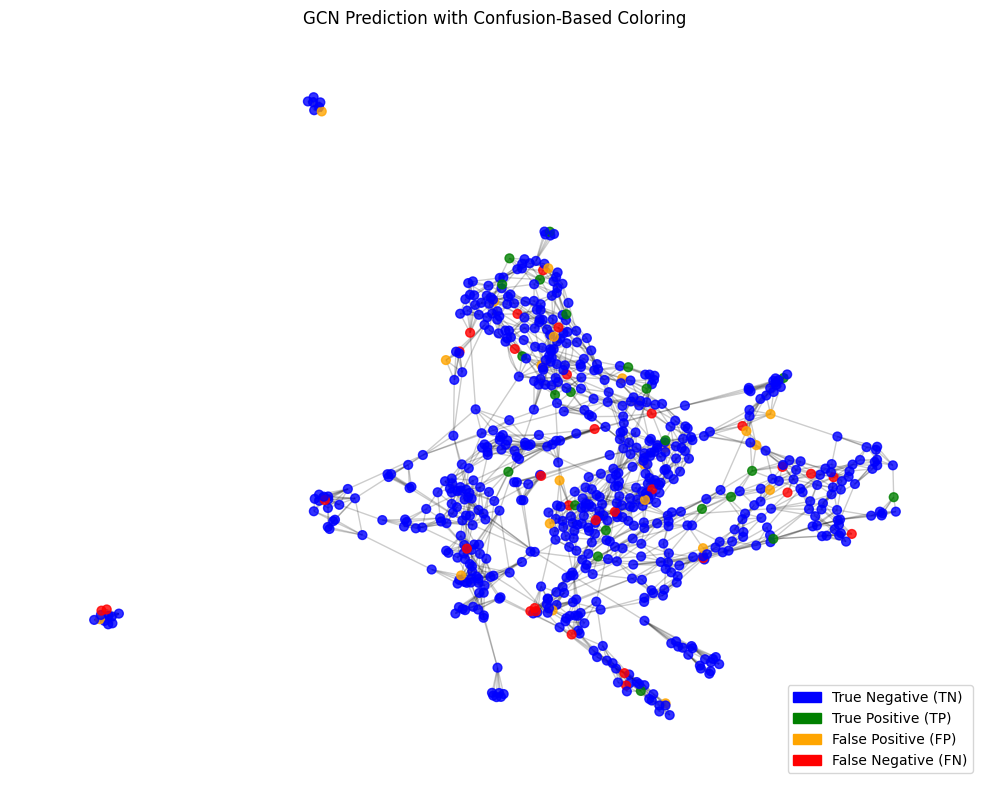

예측 분포: (array([0, 1]), array([687,  26]))
실제 라벨 분포: (array([0., 1.], dtype=float32), array([660,  53]))

Threshold Tuning:
------------------
Threshold 0.1 → F1 Score: 0.3318
Threshold 0.2 → F1 Score: 0.4182
Threshold 0.3 → F1 Score: 0.4536
Threshold 0.4 → F1 Score: 0.4390
Threshold 0.5 → F1 Score: 0.4557
Threshold 0.6 → F1 Score: 0.3947
Threshold 0.7 → F1 Score: 0.3636
Threshold 0.8 → F1 Score: 0.3385

Best Threshold Evaluation
--------------------------
Best Threshold: 0.50
AUC-ROC     : 0.8097
AUC-PR      : 0.4671
Accuracy    : 0.9397
Precision   : 0.6923
Recall      : 0.3396
F1 Score    : 0.4557


{'best_threshold': 0.5,
 'auc_roc': 0.8097484276729561,
 'auc_pr': 0.46710071131762054,
 'accuracy': 0.9396914446002805,
 'precision': 0.6923076923076923,
 'recall': 0.33962264150943394,
 'f1': 0.45569620253164556}

In [3]:
# PyG Data 객체로 변환best_val_loss
from visev import *
from AnomalyGCN import *

data_train_e = build_euclidian_graph(df_train)
data_val_e = build_euclidian_graph(df_val)
data_test_e = build_euclidian_graph(df_test)


input_dim = data_train_e.x.shape[1]
model_GCM = AnomalyGCN(in_channels=input_dim, hidden_channels=48, out_channels=1)
trained_model = train_gcn(model_GCM, data_train_e, data_val_e)

# 테스트 시각화
#visualize_graph(data_test, model=model_GCM, threshold=0.3, title="GCN Prediction with Confusion-Based Coloring")
visualize_graph(data_test_e, model=trained_model, threshold=0.3, title="GCN Prediction with Confusion-Based Coloring")
evaluate(trained_model, data_test_e)




Early stopping triggered.


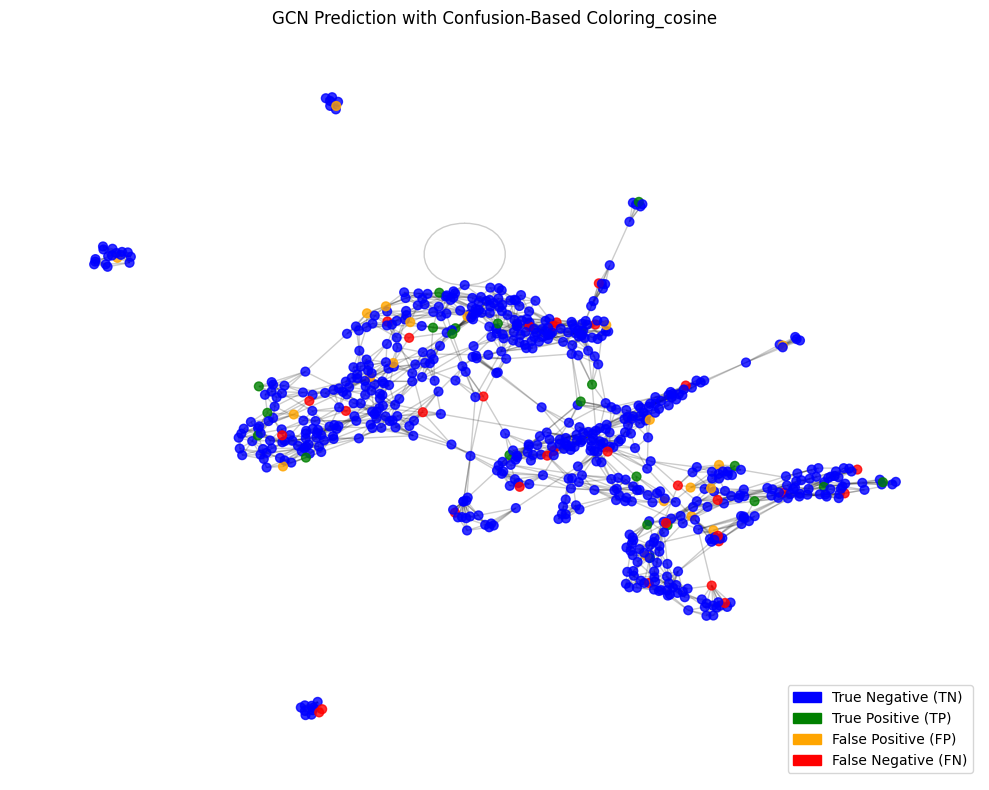

예측 분포: (array([0, 1]), array([693,  20]))
실제 라벨 분포: (array([0., 1.], dtype=float32), array([660,  53]))

Threshold Tuning:
------------------
Threshold 0.1 → F1 Score: 0.3333
Threshold 0.2 → F1 Score: 0.4174
Threshold 0.3 → F1 Score: 0.4583
Threshold 0.4 → F1 Score: 0.4615
Threshold 0.5 → F1 Score: 0.4384
Threshold 0.6 → F1 Score: 0.4225
Threshold 0.7 → F1 Score: 0.3385
Threshold 0.8 → F1 Score: 0.2857

Best Threshold Evaluation
--------------------------
Best Threshold: 0.40
AUC-ROC     : 0.8177
AUC-PR      : 0.4814
Accuracy    : 0.9411
Precision   : 0.7200
Recall      : 0.3396
F1 Score    : 0.4615


{'best_threshold': 0.4,
 'auc_roc': 0.8176958261863924,
 'auc_pr': 0.4813953080707307,
 'accuracy': 0.94109396914446,
 'precision': 0.72,
 'recall': 0.33962264150943394,
 'f1': 0.46153846153846156}

In [5]:
# PyG Data 객체로 변환best_val_loss

from visev import *
from AnomalyGCN import *

data_train_c = build_cosine_graph(df_train)
data_val_c = build_cosine_graph(df_val)
data_test_c = build_cosine_graph(df_test)

input_dim = data_train_c.x.shape[1]
model_GCM = AnomalyGCN(in_channels=input_dim, hidden_channels=48, out_channels=1)
trained_model = train_gcn(model_GCM, data_train_c, data_val_c)

# 테스트 시각화
visualize_graph(data_test_c, model=trained_model, threshold=0.3, title="GCN Prediction with Confusion-Based Coloring_cosine")
evaluate(trained_model, data_test_c)




# GAT

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from visev import *
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# GNN 모델 정의 (GAT(Graph Attention Convolution) 기반)
class AnomalyGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(AnomalyGAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.gat2 = GATConv(hidden_channels*heads, hidden_channels, heads=heads, dropout=0.3)
        #self.gat3 = GATConv(hidden_channels*heads, hidden_channels, heads=heads, dropout=0.3)
        self.gat4 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.gat2(x, edge_index)
        x = F.relu(x)
        #x = self.gat3(x, edge_index)
        #x = F.elu(x)
        x = self.gat4(x, edge_index)
        return x

# 훈련 루프 (Early Stopping 포함)
def train_c(model, data_train, data_val, epochs=150, lr=0.01, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.BCEWithLogitsLoss()
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_train.x, data_train.edge_index).squeeze()
        loss = criterion(out, data_train.y)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(data_val.x, data_val.edge_index).squeeze()
            val_loss = criterion(val_out, data_val.y)
            val_preds = torch.sigmoid(val_out).cpu().numpy()
            val_labels = data_val.y.cpu().numpy()
            val_auc = roc_auc_score(val_labels, val_preds)

        #print(f"Epoch {epoch:03d}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val AUC: {val_auc:.4f}")

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
            
    model_path= os.path.join(save_dir, "GAT_best_model_cosine")

    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), model_path)
    return model

# 테스트 데이터셋 시각화
def visualize_graph(data, title="Graph Visualization"):
    edge_list = data.edge_index.t().cpu().numpy()
    G = nx.Graph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G, seed=42)
    labels = data.y.cpu().numpy()
    node_colors = ["red" if label == 1 else "blue" for label in labels]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.show()


Early stopping triggered.


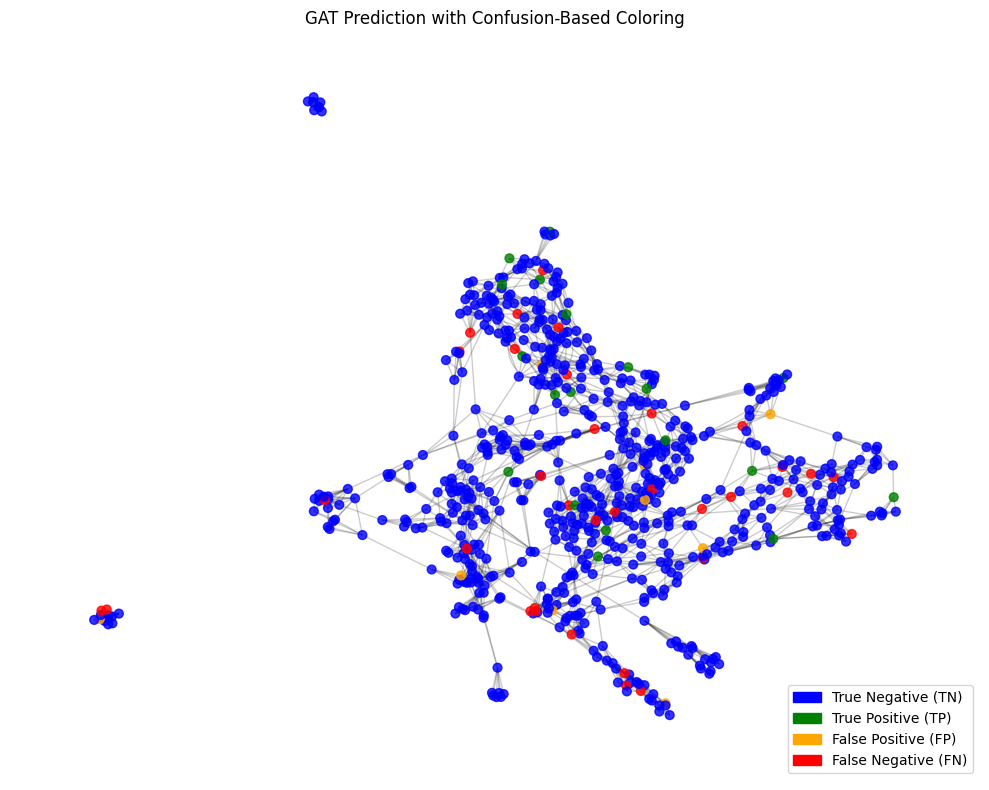

예측 분포: (array([0, 1]), array([697,  16]))
실제 라벨 분포: (array([0., 1.], dtype=float32), array([660,  53]))

Threshold Tuning:
------------------
Threshold 0.1 → F1 Score: 0.3175
Threshold 0.2 → F1 Score: 0.4211
Threshold 0.3 → F1 Score: 0.4348
Threshold 0.4 → F1 Score: 0.4634
Threshold 0.5 → F1 Score: 0.3768
Threshold 0.6 → F1 Score: 0.3582
Threshold 0.7 → F1 Score: 0.3125
Threshold 0.8 → F1 Score: 0.2857

Best Threshold Evaluation
--------------------------
Best Threshold: 0.40
AUC-ROC     : 0.8393
AUC-PR      : 0.4734
Accuracy    : 0.9383
Precision   : 0.6552
Recall      : 0.3585
F1 Score    : 0.4634


{'best_threshold': 0.4,
 'auc_roc': 0.8393367638650657,
 'auc_pr': 0.47341287746475436,
 'accuracy': 0.938288920056101,
 'precision': 0.6551724137931034,
 'recall': 0.3584905660377358,
 'f1': 0.4634146341463415}

In [9]:
from visev import *
from AnomalyGAT import *

"""
# PyG Data 객체로 변환
data_train = build_graph(df_train)
data_val = build_graph(df_val)
data_test = build_graph(df_test)
"""
model_GAT = AnomalyGAT(in_channels=21, hidden_channels=48, out_channels=1)
trained_model = train_c(model_GAT, data_train_e, data_val_e)

# 테스트 시각화
visualize_graph(data_test_e, model=trained_model, threshold= 0.4, title="GAT Prediction with Confusion-Based Coloring")
evaluate(trained_model, data_test_e)

Early stopping triggered.


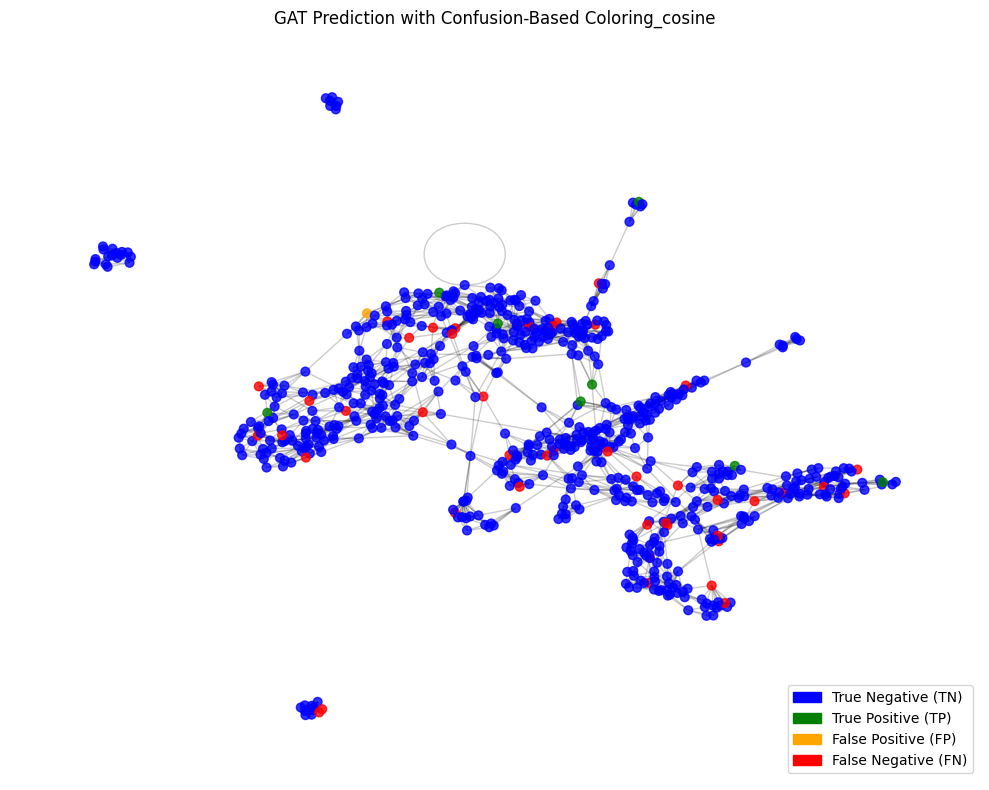

예측 분포: (array([0, 1]), array([704,   9]))
실제 라벨 분포: (array([0., 1.], dtype=float32), array([660,  53]))

Threshold Tuning:
------------------
Threshold 0.1 → F1 Score: 0.4466
Threshold 0.2 → F1 Score: 0.4211
Threshold 0.3 → F1 Score: 0.3125
Threshold 0.4 → F1 Score: 0.2857
Threshold 0.5 → F1 Score: 0.2581
Threshold 0.6 → F1 Score: 0.2581
Threshold 0.7 → F1 Score: 0.2581
Threshold 0.8 → F1 Score: 0.2000

Best Threshold Evaluation
--------------------------
Best Threshold: 0.10
AUC-ROC     : 0.8422
AUC-PR      : 0.4721
Accuracy    : 0.9201
Precision   : 0.4600
Recall      : 0.4340
F1 Score    : 0.4466


{'best_threshold': 0.1,
 'auc_roc': 0.8422384219554031,
 'auc_pr': 0.4720582869155978,
 'accuracy': 0.9200561009817672,
 'precision': 0.46,
 'recall': 0.4339622641509434,
 'f1': 0.44660194174757284}

In [11]:
from visev import *
from AnomalyGAT import *

model_GAT = AnomalyGAT(in_channels=21, hidden_channels=48, out_channels=1)
trained_model = train_c(model_GAT, data_train_c, data_val_c)

# 테스트 시각화
visualize_graph(data_test_c, model=trained_model, threshold= 0.4, title="GAT Prediction with Confusion-Based Coloring_cosine")
evaluate(trained_model, data_test_c)
